In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.decomposition import PCA, KernelPCA

from sklearn.manifold import TSNE
import os
import cv2
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib import offsetbox
import seaborn as sns

### Apply PCA and T-SNE analysis on [CK+ (mini) dataset](https://www.kaggle.com/shawon10/ckplus)

In [2]:
categories = ['anger','contempt','disgust','fear','happy','sadness','surprise']
data_path = r'./data/CK+48'
data = []
labels = []

for idx,cate in enumerate(categories):
    cate_path = data_path + '/' + cate
    img_list = os.listdir(cate_path)
    for img in img_list:
        img_path = cate_path + '/' + img
        #input_img = cv2.imread(img_path).reshape(-1,3)
        input_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).reshape(2304,)
        #gray = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        data.append(input_img)
        labels.append(idx)
        
# raw == data in old cold       
raw = np.array(data)

In [7]:
raw.shape

(981, 2304)

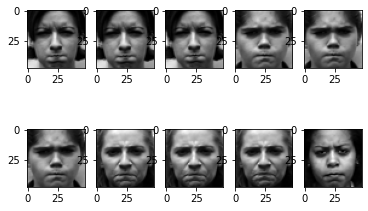

In [3]:
for i,img in enumerate(data[:10]):
    plt.subplot(2,5,i+1)
    plt.imshow(img.reshape(48,48), cmap='gray')
plt.show()

In [10]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)
print(pca.explained_variance_ratio_)

[0.39512117 0.09231498]


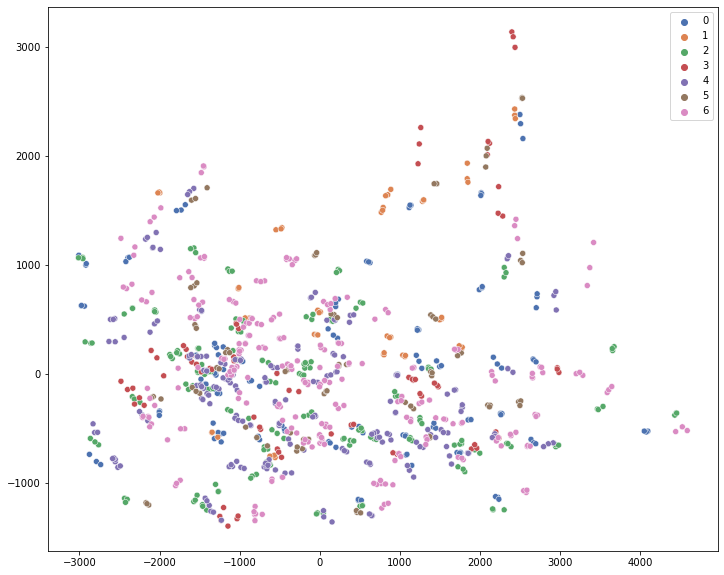

In [11]:
fig= plt.figure(figsize=(12,10))
sns.scatterplot(x=data_pca[:,0],y=data_pca[:,1], hue=labels, palette='deep')
plt.show()

In [12]:
# pca = PCA(n_components=50)
# data_pca_50 = pca.fit_transform(data)
tsne = TSNE(n_components=2, perplexity=80, learning_rate=250, random_state=0, init='pca', n_iter=5000)
#tsne = TSNE(init='pca')
data_tsne = tsne.fit_transform(data)
print(data_tsne[:5])

[[2828.4988   487.57477]
 [2804.9094   418.63577]
 [2765.1045   474.54   ]
 [2105.6318   934.5656 ]
 [2164.797    971.132  ]]


<AxesSubplot:>

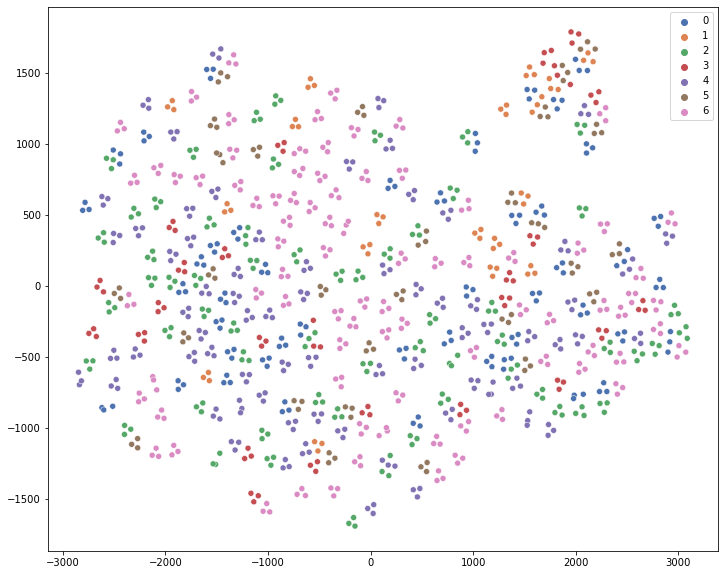

In [13]:
fig= plt.figure(figsize=(12,10))
sns.scatterplot(x=data_tsne[:,0],y=data_tsne[:,1], hue=labels, palette='deep')

### Implement basic classifier

In [18]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [414]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
#device = 'cpu'
print(device)

cuda:0


In [20]:
categories = ['anger','contempt','disgust','fear','happy','sadness','surprise']
data_path = r'./data/CK+48'
paths = []
img_labels = []

for idx,cate in enumerate(categories):
    cate_path = data_path + '/' + cate
    img_list = os.listdir(cate_path)
    for img in img_list:
        img_path = cate_path + '/' + img
        paths.append(img_path)
        img_labels.append(idx)

In [21]:
class Dataset(torch.utils.data.Dataset):
    # Characterizes a dataset for PyTorch
    def __init__(self, paths, img_labels, transform):
        'Initialization'
        self.labels = img_labels
        self.paths = paths
        self.transform = transform

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.paths)

    def __getitem__(self, index):
        # Generates one sample of data
        # Select sample
        path = self.paths[index]

        # Load data and get label
        raw = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        X = transform(raw) 
        y = self.labels[index]

        return X, y

In [22]:
# Parameters
batch_size = 32
max_epochs = 10

In [23]:
transform = transforms.Compose([
        transforms.ToTensor()
    ])
dataset = Dataset(paths, img_labels, transform)

In [24]:
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

In [112]:
train_loader = torch.utils.data.DataLoader(dataset, sampler=train_indices, batch_size=batch_size, num_workers=0)
test_loader = torch.utils.data.DataLoader(dataset, sampler=val_indices, batch_size=batch_size, num_workers=0)

In [67]:
class ClassifierNet(nn.Module):
    def __init__(self):
        super(ClassifierNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, (5,5), padding=2)
        self.conv2 = nn.Conv2d(6, 16, (5,5), padding=2)
        self.conv3 = nn.Conv2d(16, 64,(3,3))
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*5*5, 128)
        self.fc2 = nn.Linear(128, 7)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) #(N,6,W/2,H/2) = (N,6,24,24)
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x))) #(N,16,W/4,H/4) = (N,16,12,12)
        #print(x.shape)
        x = self.pool(F.relu(self.conv3(x))) #(N,64,W/8-1,W/8-1) = (N,64,5,5)
        #print(x.shape)
        x = x.view(-1, 64*5*5)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


net = ClassifierNet().to(device)

In [68]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [69]:
total_loss = []

for epoch in range(100):  
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss))
            total_loss.append(running_loss)
            running_loss = 0.0
            

print('Finished Training')

[1,    10] loss: 18.971
[1,    20] loss: 18.386
[2,    10] loss: 17.955
[2,    20] loss: 17.481
[3,    10] loss: 16.090
[3,    20] loss: 13.557
[4,    10] loss: 11.231
[4,    20] loss: 9.459
[5,    10] loss: 8.439
[5,    20] loss: 7.145
[6,    10] loss: 6.499
[6,    20] loss: 5.716
[7,    10] loss: 5.134
[7,    20] loss: 4.799
[8,    10] loss: 4.054
[8,    20] loss: 4.073
[9,    10] loss: 3.266
[9,    20] loss: 3.414
[10,    10] loss: 2.937
[10,    20] loss: 2.735
[11,    10] loss: 2.856
[11,    20] loss: 2.222
[12,    10] loss: 2.519
[12,    20] loss: 2.347
[13,    10] loss: 2.211
[13,    20] loss: 1.814
[14,    10] loss: 1.681
[14,    20] loss: 1.496
[15,    10] loss: 1.264
[15,    20] loss: 1.268
[16,    10] loss: 1.442
[16,    20] loss: 1.318
[17,    10] loss: 1.567
[17,    20] loss: 1.209
[18,    10] loss: 1.162
[18,    20] loss: 1.055
[19,    10] loss: 0.863
[19,    20] loss: 0.701
[20,    10] loss: 1.028
[20,    20] loss: 0.665
[21,    10] loss: 0.682
[21,    20] loss: 0.526
[22

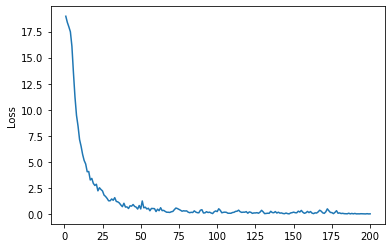

In [74]:
plt.plot(range(1,201),total_loss)
plt.ylabel("Loss")
plt.show()

In [75]:
test_dataiter = iter(test_loader)

GroundTruth:  surprise happy contempt happy anger surprise surprise happy
Predicted:  surprise happy contempt happy anger surprise surprise happy


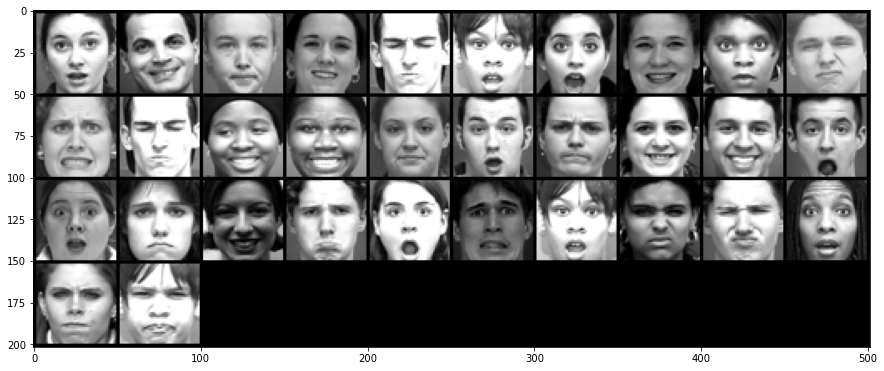

In [76]:
images, labels = test_dataiter.next()

# print images
grid = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(grid.permute(1,2,0))
print('GroundTruth: ', ' '.join('%5s' % categories[labels[j]] for j in range(8)))

images = images.to(device)
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % categories[predicted[j]] for j in range(8)))

In [77]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 100 %


### Implement image autoencoder

o = output

p = padding

k = kernel_size

s = stride

d = dilation

o = [i + 2*p - k - (k-1)*(d-1)]/s + 1

In [416]:
device = 'cpu'

In [420]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, (3,3), padding=1)
        self.conv2 = nn.Conv2d(16, 32, (3,3), padding=1)
        self.conv3 = nn.Conv2d(32, 64,(3,3), padding=1)
        
        self.conv4 = nn.Conv2d(64, 32, (3,3), padding=1)
        self.conv5 = nn.Conv2d(32, 16, (3,3), padding=1)
        self.conv6 = nn.Conv2d(16, 1, (3,3), padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*6*6, 384) #384 = latent size
        self.fc2 = nn.Linear(384, 64*6*6)
        self.dropout = nn.Dropout(0.1)
        self.upsample = nn.Upsample(scale_factor=2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) #(N,6,W/2,H/2) = (N,6,24,24)
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x))) #(N,16,W/4,H/4) = (N,16,12,12)
        #print(x.shape)
        x = self.pool(F.relu(self.conv3(x))) #(N,64,W/8,W/8) = (N,64,6,6)
        #print(x.shape)
        
        x = x.view(-1, 64*6*6)
        x = F.relu(self.fc1(x))
        
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = x.view(-1,64,6,6)
        
        x = self.conv4(self.upsample(x)) # (N,32,12,12)
        x = self.conv5(self.upsample(x)) # (N,16,24,24)
        x = self.conv6(self.upsample(x))

        return F.sigmoid(x)

autoencoder = Autoencoder().to(device)

In [407]:
# class Autoencoder(nn.Module):
#     def __init__(self):
#         super(Autoencoder, self).__init__()
#         self.enc1 = nn.Conv2d(1, 16, (4,4), stride=2, padding=1)
#         self.enc2 = nn.Conv2d(16, 32, (4,4), stride=2, padding=1)
#         self.enc3 = nn.Conv2d(32, 64, (4,4), stride=2, padding=1)
#         self.enc4 = nn.Conv2d(64, 128, (4,4), stride=2, padding=0)
        
#         self.dec1 = nn.ConvTranspose2d(128, 64, (4,4), stride=2, padding=0)
#         self.dec2 = nn.ConvTranspose2d(64, 32, (4,4), stride=2, padding=1)
#         self.dec3 = nn.ConvTranspose2d(32, 16, (4,4), stride=2, padding=1)
#         self.dec4 = nn.ConvTranspose2d(16, 1, (4,4), stride=2, padding=1)
        
#         self.fc1 = nn.Linear(512,256)
#         self.fc2 = nn.Linear(256,512)
        
#         self.dropout = nn.Dropout(0.1)
        
#     def forward(self, x):
#         x = F.relu(self.enc1(x))
#         x = F.relu(self.enc2(x))
#         x = F.relu(self.enc3(x))
#         x = F.relu(self.enc4(x)) # (N,64,2,2)
#         batch, _, _, _ = x.shape   
#         x = x.view(batch,-1)
        
#         x = self.fc1(x)
#         x = self.dropout(x)
#         x = self.fc2(x)
        
#         x = x.view(batch,128,2,2)
#         x = F.relu(self.dec1(x))
#         x = F.relu(self.dec2(x))
#         x = F.relu(self.dec3(x))
#         x = F.relu(self.dec4(x))
#         x = F.sigmoid(x)
                  
#         return x

# autoencoder = Autoencoder().to(device)

In [421]:
criterion = nn.BCELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

In [422]:
for epoch in range(200):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = autoencoder(inputs)
        #print(torch.sum(outputs))

        #print(outputs.shape)
        loss = criterion(outputs,inputs) ## loss fucntion on original images
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss))
            running_loss = 0.0

print('Finished Training')

[1,    10] loss: 6.493
[1,    20] loss: 6.120
[2,    10] loss: 5.794
[2,    20] loss: 5.698
[3,    10] loss: 5.585
[3,    20] loss: 5.560
[4,    10] loss: 5.470
[4,    20] loss: 5.488
[5,    10] loss: 5.418
[5,    20] loss: 5.431
[6,    10] loss: 5.378
[6,    20] loss: 5.398
[7,    10] loss: 5.347
[7,    20] loss: 5.370
[8,    10] loss: 5.321
[8,    20] loss: 5.346
[9,    10] loss: 5.304
[9,    20] loss: 5.327
[10,    10] loss: 5.275
[10,    20] loss: 5.300
[11,    10] loss: 5.260
[11,    20] loss: 5.287
[12,    10] loss: 5.242
[12,    20] loss: 5.268
[13,    10] loss: 5.232
[13,    20] loss: 5.257
[14,    10] loss: 5.224
[14,    20] loss: 5.251
[15,    10] loss: 5.228
[15,    20] loss: 5.251
[16,    10] loss: 5.208
[16,    20] loss: 5.228
[17,    10] loss: 5.205
[17,    20] loss: 5.224
[18,    10] loss: 5.198
[18,    20] loss: 5.222
[19,    10] loss: 5.197
[19,    20] loss: 5.212
[20,    10] loss: 5.172
[20,    20] loss: 5.196
[21,    10] loss: 5.161
[21,    20] loss: 5.188
[22,    10

[169,    20] loss: 5.049
[170,    10] loss: 5.025
[170,    20] loss: 5.052
[171,    10] loss: 5.023
[171,    20] loss: 5.055
[172,    10] loss: 5.026
[172,    20] loss: 5.056
[173,    10] loss: 5.027
[173,    20] loss: 5.053
[174,    10] loss: 5.025
[174,    20] loss: 5.053
[175,    10] loss: 5.019
[175,    20] loss: 5.052
[176,    10] loss: 5.022
[176,    20] loss: 5.052
[177,    10] loss: 5.028
[177,    20] loss: 5.057
[178,    10] loss: 5.024
[178,    20] loss: 5.055
[179,    10] loss: 5.027
[179,    20] loss: 5.057
[180,    10] loss: 5.027
[180,    20] loss: 5.056
[181,    10] loss: 5.022
[181,    20] loss: 5.052
[182,    10] loss: 5.021
[182,    20] loss: 5.051
[183,    10] loss: 5.018
[183,    20] loss: 5.051
[184,    10] loss: 5.018
[184,    20] loss: 5.049
[185,    10] loss: 5.015
[185,    20] loss: 5.048
[186,    10] loss: 5.015
[186,    20] loss: 5.044
[187,    10] loss: 5.014
[187,    20] loss: 5.045
[188,    10] loss: 5.015
[188,    20] loss: 5.042
[189,    10] loss: 5.013


In [423]:
test_dataiter = iter(test_loader)

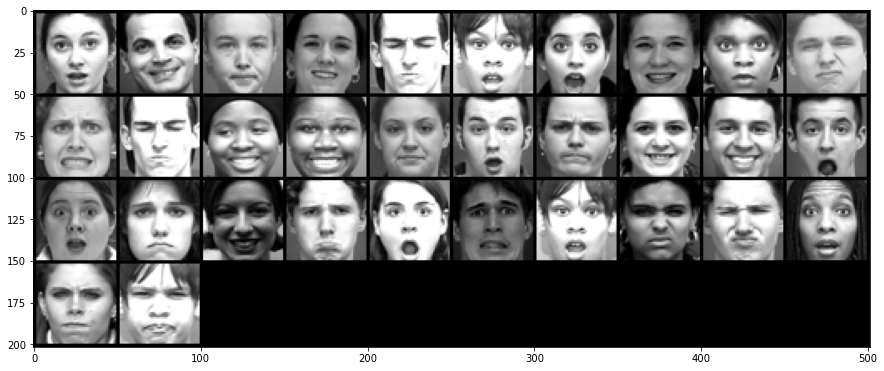

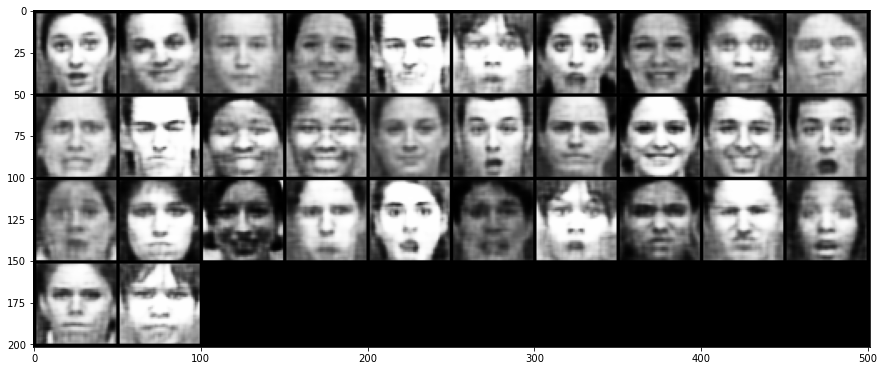

In [424]:
images, labels = test_dataiter.next()


# print images
images = images.to(device)
derived_images = autoencoder(images)
grid = torchvision.utils.make_grid(images.cpu(), nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(grid.permute(1,2,0))
plt.show()

grid = torchvision.utils.make_grid(derived_images.detach().cpu(), nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(grid.permute(1,2,0))
plt.show()